<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter12/Face_generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset/
!unzip -qq celeba-dataset.zip
!rm celeba-dataset.zip

Saving kaggle.json to kaggle.json
kaggle.json
 98% 1.31G/1.33G [00:16<00:00, 59.2MB/s]
100% 1.33G/1.33G [00:17<00:00, 83.6MB/s]


In [ ]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
device = "cuda" if torch.cuda.is_available() else "cpu"

     |████████████████████████████████| 36.7MB 92kB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 


In [ ]:
import cv2, numpy as np, pandas as pd

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [ ]:
device

'cuda'

In [ ]:
!mkdir img_align_celeba_cropped_faces
images = sorted(Glob('img_align_celeba/img_align_celeba/*'))
for i in range(100000):
    if(i%10000==0):
        print(i)
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('img_align_celeba_cropped_faces/'+images[i].split('/')[-1],cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

mkdir: cannot create directory ‘img_align_celeba_cropped_faces’: File exists


2020-10-04 10:22:22.262 | INFO     | torch_snippets.loader:Glob:160 - 202599 files found at img_align_celeba/img_align_celeba/*


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [ ]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [ ]:
data = pd.read_csv('list_attr_celeba.csv')
folder='img_align_celeba_cropped_faces/'

In [ ]:
class Celeba(Dataset):
    def __init__(self, folder, data):
        super().__init__()
        self.image_root = folder
        self.folder = folder
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, ix):
        row = self.data.iloc[ix]
        image_path = f'{self.folder}/{row.image_id}'
        image = Image.open(image_path)
        image = transform(image)
        return image

In [ ]:
ds = Celeba(folder='img_align_celeba_cropped_faces/', data=data.loc[:99999])

In [ ]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [ ]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [ ]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [ ]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction, torch.ones(len(real_data), 1).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


EPOCH: 1.000	d_loss: 0.544	g_loss: 3.304	(180.60s - 4334.46s remaining)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


EPOCH: 1.000	d_loss: 0.616	g_loss: 6.028	(180.79s - 4338.94s remaining)
EPOCH: 2.000	d_loss: 0.643	g_loss: 3.633	(358.95s - 4127.98s remaining)
EPOCH: 3.000	d_loss: 0.704	g_loss: 2.977	(537.61s - 3942.50s remaining)
EPOCH: 4.000	d_loss: 0.689	g_loss: 2.762	(715.24s - 3755.00s remaining)
EPOCH: 5.000	d_loss: 0.672	g_loss: 2.729	(893.48s - 3573.90s remaining)
EPOCH: 6.000	d_loss: 0.654	g_loss: 2.737	(1071.44s - 3392.90s remaining)
EPOCH: 7.000	d_loss: 0.604	g_loss: 2.804	(1249.75s - 3213.65s remaining)
EPOCH: 8.000	d_loss: 0.588	g_loss: 2.848	(1427.37s - 3033.16s remaining)
EPOCH: 9.000	d_loss: 0.547	g_loss: 3.005	(1605.02s - 2853.37s remaining)
EPOCH: 10.000	d_loss: 0.519	g_loss: 3.091	(1782.95s - 2674.42s remaining)
EPOCH: 11.000	d_loss: 0.482	g_loss: 3.211	(1960.67s - 2495.40s remaining)
EPOCH: 12.000	d_loss: 0.438	g_loss: 3.330	(2138.67s - 2316.89s remaining)
EPOCH: 13.000	d_loss: 0.441	g_loss: 3.418	(2316.17s - 2138.00s remaining)
EPOCH: 14.000	d_loss: 0.396	g_loss: 3.560	(2493.90s 

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 68%|██████▊   | 17/25 [00:00<00:00, 164.51it/s]

EPOCH: 25.000	d_loss: 0.302	g_loss: 4.259	(4450.40s - 0.00s remaining)


100%|██████████| 25/25 [00:00<00:00, 114.82it/s]


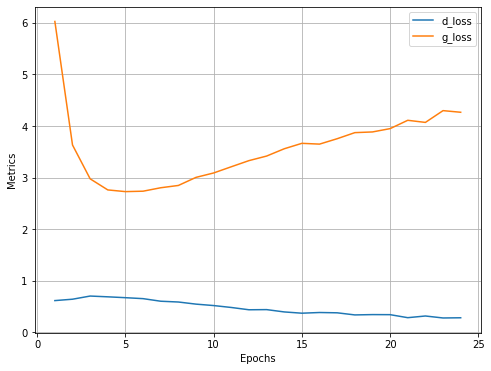

In [ ]:
log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

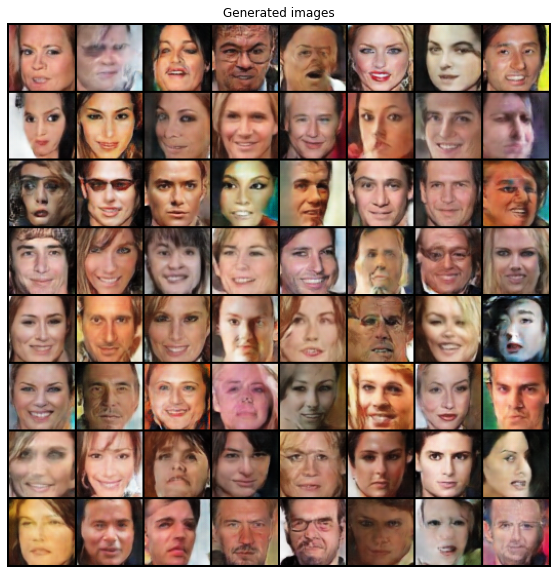

In [ ]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')